In [1]:
import pickle
from diffusion.sampling import *
from diffusion.likelihood import mmff_energy
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True 
import py3Dmol
from rdkit import Chem, Geometry
from ipywidgets import interact, Dropdown
import matplotlib.pyplot as plt
from rdkit.Chem import rdMolAlign 
from termcolor import colored 
from rdkit.Chem import rdMolTransforms
from utils.standardization import fast_rmsd
from torch_geometric.data import Data, Batch

/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_geometric/typing.py:99: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(
/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
def get_bond_lengths(mol):
    assert mol.GetNumConformers() == 1
    bond_lengths = []
    for bond in mol.GetBonds():
        bond_lengths.append(rdMolTransforms.GetBondLength(mol.GetConformer(),bond.GetBeginAtom().GetIdx(), bond.GetEndAtom().GetIdx() ) )
    return torch.Tensor(bond_lengths)

def get_bond_angles(mol):
    assert mol.GetNumConformers() == 1
    bond_angles = []
    for bond in mol.GetBonds():
        atom1 = bond.GetBeginAtom()
        atom2 = bond.GetEndAtom()
        for neighbor in atom2.GetNeighbors():
            if neighbor.GetIdx() != atom1.GetIdx():
                angle = rdMolTransforms.GetAngleRad(mol.GetConformer(),   
                                                    atom1.GetIdx(), 
                                                    atom2.GetIdx(), 
                                                    neighbor.GetIdx())
                bond_angles.append(angle)
    return torch.Tensor(bond_angles)

def get_torsion_angles(mol):
    assert mol.GetNumConformers() == 1
    torsion_angles = []
    for bond in mol.GetBonds():
        atom1 = bond.GetBeginAtom()
        atom2 = bond.GetEndAtom()
        
        # Get neighboring atoms
        for neighbor1 in atom2.GetNeighbors():
            if neighbor1.GetIdx() != atom1.GetIdx():
                # Calculate the angle
                for neighbor2 in neighbor1.GetNeighbors():
                    if neighbor2.GetIdx() != atom2.GetIdx() and neighbor2.GetIdx() != atom1.GetIdx():
                        torsion = rdMolTransforms.GetDihedralRad(mol.GetConformer(), 
                                                                 atom1.GetIdx(), 
                                                                 atom2.GetIdx(), 
                                                                 neighbor1.GetIdx(), 
                                                                 neighbor2.GetIdx())
                        torsion_angles.append(torsion)
    return torch.Tensor(torsion_angles)

def get_stds_internal_coords(mols):
    
    all_bond_lengths = [get_bond_lengths(mol) for mol in mols]
    all_bond_angles = [get_bond_angles(mol) for mol in mols]
    all_torsion_angles = [get_torsion_angles(mol) for mol in mols]
    bond_lengths_std = torch.stack(all_bond_lengths).std(dim=0).mean()
    bond_angles_std = torch.stack(all_bond_angles).std(dim=0).mean()
    torsion_angles_std = torch.stack(all_torsion_angles).std(dim=0).mean()
    return bond_lengths_std, bond_angles_std, torsion_angles_std

def get_rmsds(mols, mols_optimized):
    '''
    This function compares a set of molecules with their optimized versions and returns the RMSDs between each pair (non-optimized, optimized).
    '''
    rmsds = []
    for conf_idx in range(len(mols)):
        mol0, mol1 = mols[conf_idx], mols_optimized[conf_idx]
        rdMolAlign.AlignMol(mol0, mol1)
        rmsds.append(fast_rmsd(mol0, mol1 , conf1=0, conf2=0) )
    return rmsds

In [3]:
def plot_aligned_confs(data):
    mols = []
    for conf in data:
        mol = pyg_to_mol(conf.mol, conf, mmff=False, rmsd=False, copy=True)
        mols.append(mol)
    # align all mols to the first one
    for i in range(1, len(mols)):
        rdMolAlign.AlignMol(mols[i], mols[0])
    # Plot mols
    ## Convert to mol blocks
    mol_blocks = [Chem.MolToMolBlock(mol) for mol in mols]

    colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'pink', 'brown', 'grey', 'black', 'white', 'salmon', 'olive', 'lime', 'teal', 'indigo', 'violet', 'tan', 'khaki', 'gold', 'coral', 'azure', 'lavender', 'orchid', 'plum', 'crimson', 'maroon', 'sienna', 'navy', 'skyblue', 'turquoise', 'aquamarine', 'mint', 'lime', 'chartreuse', 'olive', 'khaki', 'gold', 'coral', 'salmon', 'tomato', 'orangered', 'firebrick', 'maroon', 'sienna', 'chocolate', 'saddlebrown', 'brown', 'black', 'grey', 'dimgray', 'darkgray', 'silver', 'lightgray', 'gainsboro', 'white']
    view = py3Dmol.view(width=400, height=400)
    for i, mol_block in enumerate(mol_blocks):
        view.addModel(mol_block, "mol")
        view.setStyle({'model': i}, {'stick': {'color': colors[i%len(colors)]}})

    view.addLabel('confs',{'position': {'x': 0, 'y': 8, 'z': 0}, 
                'backgroundColor': 'white', 
                'fontColor': 'black', 
                'fontSize': 16, 
                'alignment': 'topCenter'})
    view.zoomTo()
    view.show()

## Understanding relaxation

In [5]:
# load conformers_20steps.pkl
#conformers_train = pickle.load(open('true_conformers_train_1smiles.pkl', 'rb'))
conformers_train = None
conformers_gen = pickle.load(open('conformers_20steps_train_1smiles.pkl', 'rb'))
conformers_optimized = pickle.load(open('conformers_20steps_train_1smiles_optimized.pkl', 'rb'))
smis = list(conformers_gen.keys())

In [17]:
for i, smile in enumerate(smis): 
    #Plt figure with 2 subfigures
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    #mols_train, mols_gen, mols_optimized = conformers_train[smile], conformers_gen[smile], conformers_optimized[smile]
    mols_train, mols_gen, mols_optimized = conformers_train, conformers_gen[smile], conformers_optimized[smile]
    #Plot the hists in the first subfigure
    #ax[0].hist([mmff_energy(mol) for mol in mols_train], bins=20, color = 'blue', label='train', alpha=0.25  )
    ax[0].hist([mmff_energy(mol) for mol in mols_gen], bins=20, color = 'orange',label='gen', alpha=0.25)
    ax[0].hist([mmff_energy(mol) for mol in mols_optimized], bins=20, color = 'green',label='gen_optimized', alpha=0.25)
    ax[0].legend()
    ax[0].set_xscale('log')
    ax[0].set_title(f'Energy distribution')
    # Plot the RMSD in the second subfigure
    rmsds = get_rmsds(mols_gen, mols_optimized)
    ax[1].boxplot(rmsds)
    ax[1].set_title(f'RMSD(gen, optimized)')
    # add title to the whole figure
    fig.suptitle(f'Mol {i}, smile {smile}')
    #Add title for the whole figure
    i+=1
    #if i ==1:
        #break


NameError: name 'smis' is not defined

Text(0.5, 1.0, 'RMSD')

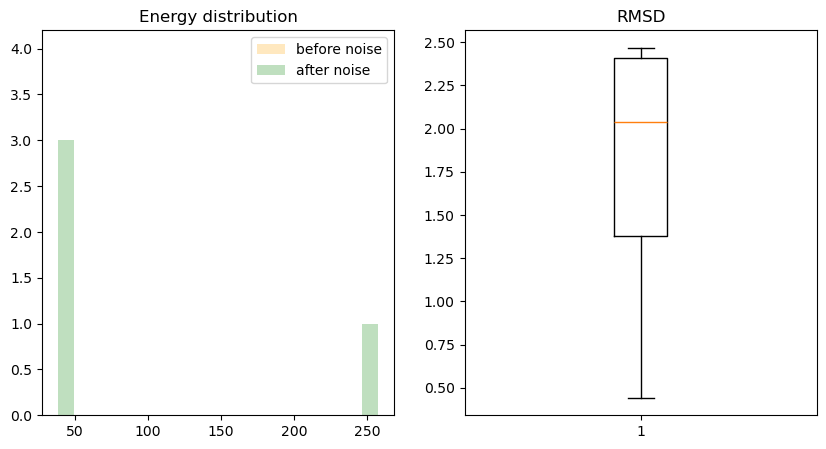

In [12]:
samples_before_perturb = pickle.load(open('samples_before_perturb.pkl', 'rb'))
samples_after_perturb = pickle.load(open('samples_after_perturb.pkl', 'rb'))
#Plt figure with 2 subfigures
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#Plot the hists in the first subfigure
ax[0].hist([mmff_energy(x.mol) for x in samples_before_perturb], bins=20, color = 'orange',label='before noise', alpha=0.25)
ax[0].hist([mmff_energy(x.mol) for x in samples_after_perturb], bins=20, color = 'green',label='after noise', alpha=0.25)
ax[0].legend()
ax[0].set_title(f'Energy distribution')
# Plot the RMSD in the second subfigure
rmsds = get_rmsds([x.mol for x in samples_before_perturb], [x.mol for x in samples_after_perturb])
ax[1].boxplot(rmsds)
ax[1].set_title(f'RMSD')


In [6]:
ix = 0
mol0 = conformers_gen[smis[0]][ix]
mol1 = samples_before_perturb[ix].mol
mol2 = samples_after_perturb[ix].mol
rdMolAlign.AlignMol(mol0, mol1)
rdMolAlign.AlignMol(mol2, mol1)
# Convert to mol blocks
mol0_block = Chem.MolToMolBlock(mol0)
mol1_block = Chem.MolToMolBlock(mol1)
mol2_block = Chem.MolToMolBlock(mol2)

view = py3Dmol.view(width=400, height=400)
view.addModel(mol0_block, "mol")
view.addModel(mol1_block, "mol")
view.addModel(mol2_block, "mol")
view.setStyle({'model': 0}, {'stick': {'color': 'green'}})
view.setStyle({'model': 1}, {'stick': {'color': 'red'}})
view.setStyle({'model': 2}, {'stick': {'color': 'blue'}})
view.addLabel('Gen (green) || Before (red) after (blue) noising}',{'position': {'x': 0, 'y': 8, 'z': 0}, 
               'backgroundColor': 'white', 
               'fontColor': 'black', 
               'fontSize': 16, 
               'alignment': 'topCenter'})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Let's look at the internal coordinate differences before vs after relaxation, for bond lengths, bond angles and torsion angles:

In [7]:
for smile in smis:
    print(f'MOL={smile}')
    bond_lengths_diffs = 0
    bond_angles_diffs = 0
    torsion_angles_diffs = 0
    mols_train, mols_gen, mols_optimized = conformers_train[smile], conformers_gen[smile], conformers_optimized[smile]
    for conf_idx in range(len(mols_train)):
        mol1, mol2 =mols_gen[conf_idx], mols_optimized[conf_idx]
        bond_lengths_diff, bond_angles_diff, torsion_angles_diff = get_stds_internal_coords([mol1, mol2])
        bond_lengths_diffs +=bond_lengths_diff
        bond_angles_diffs +=bond_angles_diff
        torsion_angles_diffs += torsion_angles_diff
    print(f'Mean Bond length std: {bond_lengths_diffs/len(mols_train):.2f} Å, Mean Bond angles std: {bond_angles_diffs/len(mols_train):.2f} rad, Mean Torsion angles std: {torsion_angles_diffs/len(mols_train):.2f} rad' )


MOL=COc1cccc(C(C[N+](=O)[O-])c2c(C)[nH]n(-c3ccccc3)c2=O)c1
Mean Bond length diff: 0.03 Å, Mean Bond angles diff: 0.08 rad, Mean Torsion angles diff: 1.32 rad
MOL=S=C(NCc1ccc2c(c1)OCO2)NC1CC1
Mean Bond length diff: 0.02 Å, Mean Bond angles diff: 0.07 rad, Mean Torsion angles diff: 1.04 rad
MOL=CCN(CC)C(C(=O)NC1CCCCC1)c1ccc(C)cc1
Mean Bond length diff: 0.02 Å, Mean Bond angles diff: 0.06 rad, Mean Torsion angles diff: 1.06 rad
MOL=Cc1nc(-c2nc(-c3c(C(=O)NNC(=O)Nc4ccccc4)noc3C)cs2)cs1
Mean Bond length diff: 0.04 Å, Mean Bond angles diff: 0.09 rad, Mean Torsion angles diff: 1.40 rad
MOL=CCC1(C)Cc2c(C#N)c(N)n(N)c(=S)c2CO1
Mean Bond length diff: 0.03 Å, Mean Bond angles diff: 0.08 rad, Mean Torsion angles diff: 1.27 rad
MOL=CC(C(=O)Nc1ccccc1F)N1CC[NH+](C)CC1
Mean Bond length diff: 0.03 Å, Mean Bond angles diff: 0.07 rad, Mean Torsion angles diff: 1.11 rad
MOL=[NH3+]CCCP(=O)(O)CCc1ccccc1
Mean Bond length diff: 0.02 Å, Mean Bond angles diff: 0.05 rad, Mean Torsion angles diff: 1.19 rad
MOL=Cc1c

Hmmmm, interesting, the torsion angles change a lot with relaxation. But why does relaxation need to go so far in terms of RMSD? Why doesn't it go to the closest 'ground-truth' conformer?

Well, if we look at the eval metrics for this set of molecules: 

 - threshold 0.75:

- Recall Coverage: Mean = 61.66, Median = 82.02

- Recall AMR: Mean = 0.6300, Median = 0.5793

- Precision Coverage: Mean = 35.80, Median = 42.31

- Precision AMR: Mean = 0.9013, Median = 0.7905

The precision AMR is around 0.9, i.e. it is the same order of magnitude of relaxtion. So the results with relaxation are not that surprising

**Training conformers after conformer matching have low energy!** Ca laisse penser que c'est le modele qui est pas assez bon

        - Plot : bond lengths and angles distribution of training conformers after confs matching. Ot has very low variance, so it makes sense to fix bond lengths/angles, and it's the diff model that is pretty bad
       
        - How does this energy compare to the energy of conformers **before confs matching?** -> voir si ça vaut vraiment le coup de fixer les bond lengths/angles ou pas

## Dataset Exploration

In [4]:
from utils.dataset import *
from utils.featurization import dihedral_pattern, featurize_mol, qm9_types, drugs_types

data_dir='/home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/DRUGS/drugs/'
split_path='/home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/DRUGS/split_boltz_10k.npy'
mode = 'train'
dataset='drugs'
#transform = TorsionNoiseTransform(sigma_min=0.01*3.14, sigma_max= 3.14,boltzmann_weight=False)
#transform = NoTransform(sigma_min=0.01*3.14, sigma_max= 3.14,boltzmann_weight=False)
transform = None
num_workers = 32
limit_molecules = 0
types = drugs_types
cache = '/home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/cache/test_run'
pickle_dir = '/home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/DRUGS/standardized_pickles'
boltzmann_resampler = None

dataset = ConformerDataset(data_dir, split_path, mode, dataset,
                                   types, transform,
                                   num_workers,
                                   limit_molecules,
                                   cache,
                                   pickle_dir,
                                   boltzmann_resampler)
print(f'Number of datapoints {len(dataset.datapoints)}')
loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

Reusing preprocessing from cache /home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/cache/test_run.train
Number of datapoints 9295


/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [30]:
conformers_train_gen = pickle.load(open('conformers_train_gen.pkl', 'rb'))
dummy_data_batch = pickle.load(open('dummy_data_batch.pkl', 'rb'))

In [31]:
Batch.from_data_list(conformers_train_gen).total_perturb.reshape(-1,3).mean(dim=0)

tensor([1.9025, 2.3062, 0.7521], dtype=torch.float64)

In [33]:
Batch.from_data_list(dummy_data_batch).total_perturb.reshape(-1,3).mean(dim=0)

tensor([0.9314, 0.9976, 0.0584])

In [34]:
plot_aligned_confs(conformers_train_gen)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [27]:
plot_aligned_confs(dummy_data_batch)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [35]:
gt_mols = [pyg_to_mol(dummy_data_batch[i].mol, dummy_data_batch[i], copy=True) for i in range(len(dummy_data_batch))]
gen_mols = [pyg_to_mol(conformers_train_gen[i].mol, conformers_train_gen[i], copy=True) for i in range(len(conformers_train_gen))]
rmsds = np.array([get_rmsds([gt_mols[i] for _ in range(len(gen_mols))], gen_mols) for i in range(len(gt_mols))])
rmsds = np.min(rmsds, axis=0)

In [37]:
np.median(rmsds)

np.float64(2.7998135865650022)

In [6]:
dummy_data_pkl, ix0, ix1 = 'dummy_data_gaussian.pkl', 0, 1
dummy_data = pickle.load(open(dummy_data_pkl, 'rb'))
smi = dummy_data[0].canonical_smi

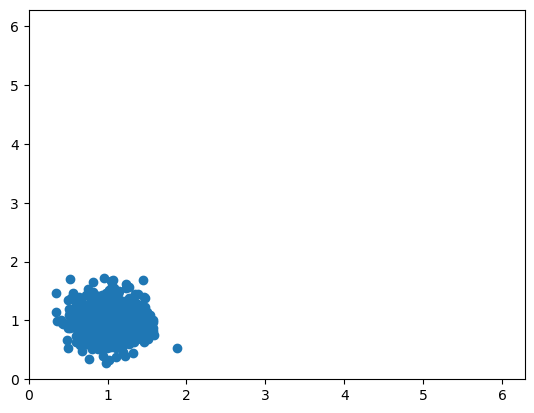

In [10]:
total_perturbs = Batch.from_data_list(dummy_data).total_perturb.reshape(-1, 3)
plt.scatter(total_perturbs[:,0], total_perturbs[:,1])
plt.xlim(0, 2*np.pi)
plt.ylim(0, 2*np.pi)
plt.show()

In [ ]:
# Visualize the wrapped normal distribution
from diffusion import torus
def get_unimode_rew(data, torsion_updates, sigma):
    
    num_torsion_angles = len(data[0].mask_rotate)
    assert len(torsion_updates) == num_torsion_angles

    p = torus.p_differentiable(torsion_updates - mean.repeat(len(data)), sigma, N=10)
    p = p.reshape(-1, num_torsion_angles).sum(dim=1)
    return p

In [ ]:
data0 = pickle.load(open(dummy_data_pkl, 'rb'))[0]
data = copy.deepcopy(data0)
torsion_update = np.ones(len(data.mask_rotate))
new_pos = modify_conformer(data.pos, data.edge_index.T[data.edge_mask], data.mask_rotate, torsion_update, as_numpy=False)
data.pos = new_pos
data.total_perturb = torch.Tensor(torsion_update)
# Save the dummy data
#pickle.dump([data], open('dummy_unimode_data.pkl', 'wb'))

In [ ]:
def create_dummy_data(smi, dummy_data_pkl, ix0, ix1):
    for batch_idx, batch in enumerate(tqdm.tqdm(loader, total=len(loader))):  # Here, loader is used to go through smiles. But in our case, we are going to focus only on one smiles
        assert len(batch) == 1
        if batch.canonical_smi[0] == smi:
            break 

    data = batch[0]
    assert transform == None
    data.pos = data.pos[0]
    torsion_angles_linspace = torch.linspace(0, 2*np.pi - 0.1,  4)
    #thetas0, thetas1 = np.random.choice(torsion_angles_linspace, 3, replace=False), np.random.choice(torsion_angles_linspace, 3, replace=False)
    thetas0, thetas1 = torsion_angles_linspace, torsion_angles_linspace
    energy_landscape = []
    dummy_data = []
    for theta0 in thetas0:
        energy_landscape.append([])
        for theta1 in thetas1:
            data0 = copy.deepcopy(data)
            torsion_update = np.zeros(len(data0.mask_rotate))
            torsion_update[ix0], torsion_update[ix1] = theta0, theta1
            new_pos = modify_conformer(data0.pos, data0.edge_index.T[data0.edge_mask], data0.mask_rotate, torsion_update, as_numpy=False) #change the value of the 1st torsion angle
            data0.pos = new_pos
            data0.total_perturb = torch.Tensor(torsion_update)
            #data0.mask_rotate = torch.tensor(data0.mask_rotate)
            dummy_data.append(copy.deepcopy(data0))
    # Save the dummy data
    pickle.dump(dummy_data, open(dummy_data_pkl, 'wb'))
    return dummy_data

In [ ]:
def get_2d_rmsd(data,ix0, ix1):
    '''
    Get 2D rmsd heatmap and 2D torsion_angles dists heatmap
    '''
    torsion_angles_linspace = torch.linspace(0, 2*np.pi, 100)
    rmsds = []
    torsion_angles_dists = []
    for theta0 in torsion_angles_linspace:
        rmsds.append([])
        torsion_angles_dists.append([])
        for theta1 in torsion_angles_linspace:
            data0 = copy.deepcopy(data)
            torsion_update = np.zeros(len(data0.mask_rotate))
            torsion_update[ix0], torsion_update[ix1] = theta0, theta1
            new_pos = modify_conformer(data0.pos, data0.edge_index.T[data0.edge_mask], data0.mask_rotate, torsion_update, as_numpy=False) #change the value of the 1st torsion angle
            data0.pos = new_pos
            mol0 = pyg_to_mol(data0.mol, data0, mmff=False, rmsd=True, copy=True)
            mol = pyg_to_mol(data.mol, data, mmff=False, rmsd=True, copy=True)
            rmsds[-1].append(fast_rmsd(mol0, mol, conf1=0, conf2=0))
            torsion_angles_dists[-1].append(min(theta1, 2 * np.pi - theta1) + min(theta0, 2 * np.pi - theta0))  
            
    return rmsds, torsion_angles_dists

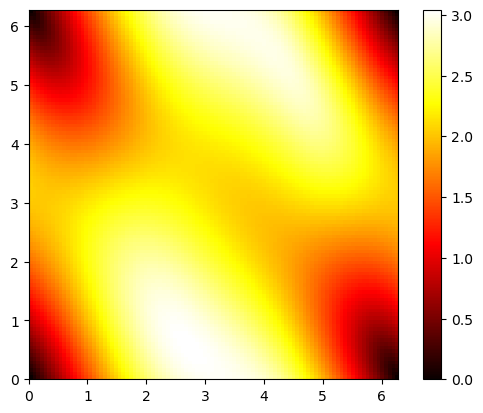

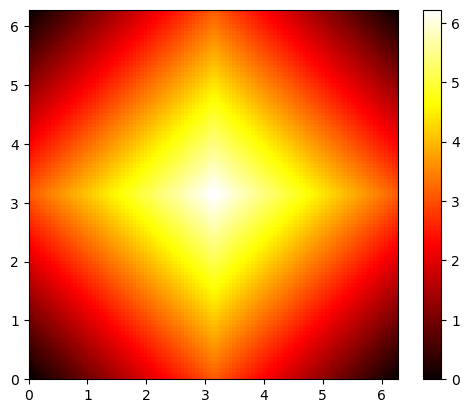

In [15]:
rmsds,torsion_angles_dists  = get_2d_rmsd(dummy_data[0] , ix0, ix1)
plt.figure()
plt.imshow(rmsds, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap='hot', interpolation='nearest')
plt.colorbar()
plt.figure()
plt.imshow(torsion_angles_dists, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap='hot', interpolation='nearest')
plt.colorbar()

In [7]:
from diffusion.score_model import TensorProductScoreModel
model = TensorProductScoreModel(in_node_features=74, in_edge_features=4,
                                   sigma_embed_dim=32,
                                   num_conv_layers=4,
                                   max_radius=5.0, radius_embed_dim=50,
                                   scale_by_sigma=True,
                                   use_second_order_repr=False,
                                   residual=True, batch_norm=True)
restart_dir = '/home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/workdir/boltz_T300'
state_dict = torch.load(f'{restart_dir}/best_model.pt', map_location=torch.device('cpu'))
model.load_state_dict(state_dict, strict=True)
sigma_max, sigma_min, steps = 0.01*3.14, 3.14, 100

/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type anno

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f'The model has {num_params} trainable parameters.')

The model has 1046104 trainable parameters.


In [12]:
def get_2dheatmap_array(data,ix0, ix1, num_points):
    '''
    Get 2Denergy heatmap. This is obtained by computing the energy for different value (linspace) of the 2 torsion angles ix0 and ix1. 
    '''
    torsion_angles_linspace = torch.linspace(0, 2*np.pi, num_points)
    mols_energy_landscape = []
    for theta0 in torsion_angles_linspace:
        mols_energy_landscape.append([])
        for theta1 in torsion_angles_linspace:
            data0 = copy.deepcopy(data)
            torsion_update = np.zeros(len(data0.mask_rotate))
            torsion_update[ix0], torsion_update[ix1] = theta0, theta1
            new_pos = modify_conformer(data0.pos, data0.edge_index.T[data0.edge_mask], data0.mask_rotate, torsion_update, as_numpy=False) #change the value of the 1st torsion angle
            data0.pos = new_pos
            mol = pyg_to_mol(data0.mol, data0, mmff=False, rmsd=True, copy=True)
            mols_energy_landscape[-1].append(mol)
    energy_landscape = [[mmff_energy(mol) for mol in mols] for mols in mols_energy_landscape]
    #print('energies (1st row)', energy_landscape[0])
    return energy_landscape
    

smi: Brc1cc2c(cc1Cn1c(-c3cncs3)nc3ccccc31)OCO2
log-energy gt optimized 3.8262064948164167


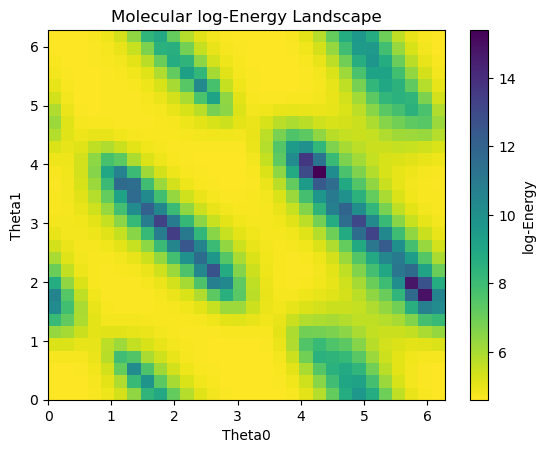

log-energy gt optimized 3.8398352898454884


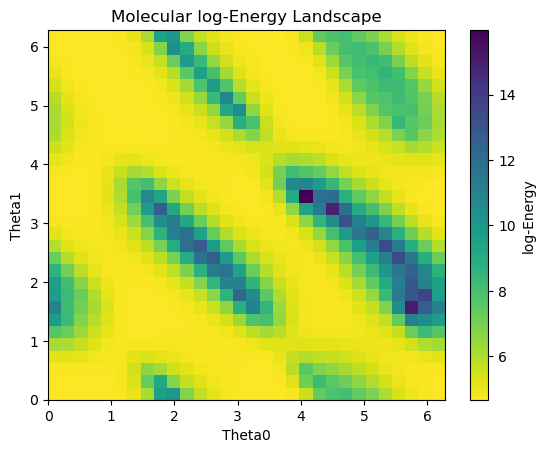

log-energy gt optimized 3.8466521901179536


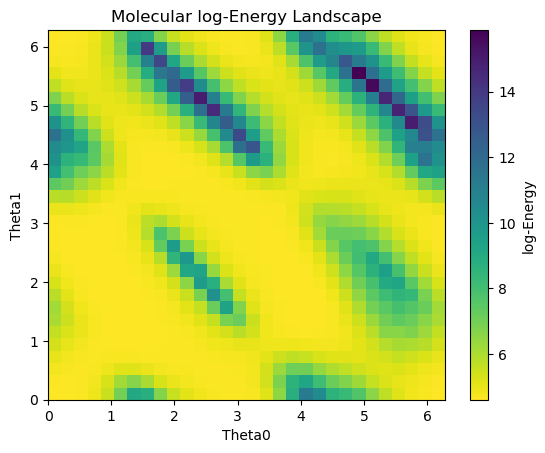

log-energy gt optimized 3.8479718571175163


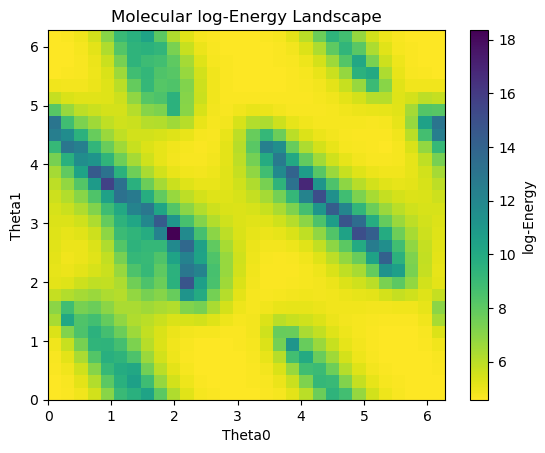

log-energy gt optimized 3.854645536299132


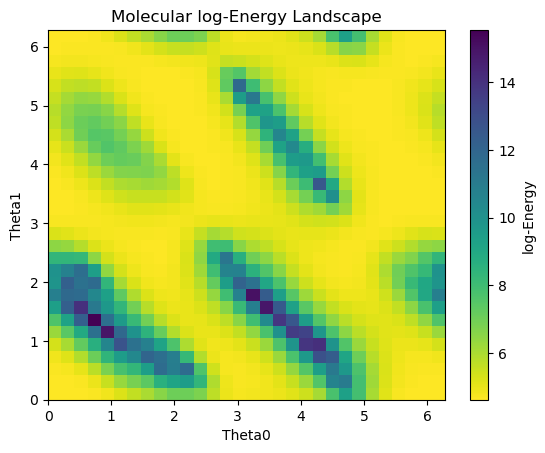

log-energy gt optimized 3.859563442208123


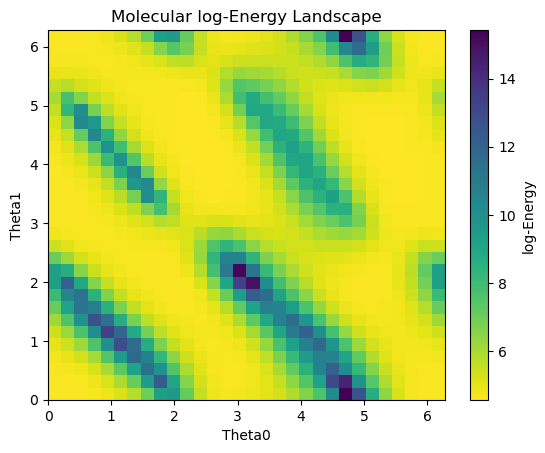

log-energy gt optimized 3.882069413761675


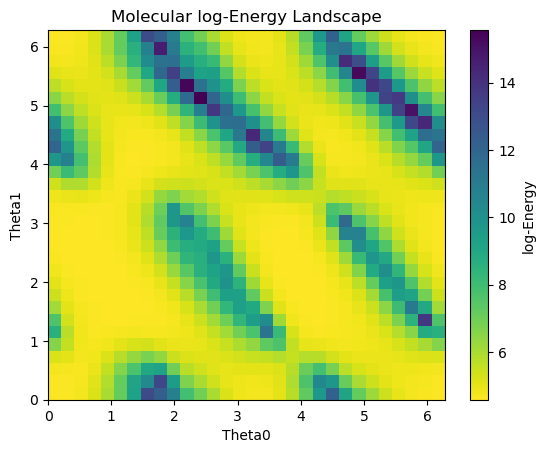

log-energy gt optimized 3.8671938246596347


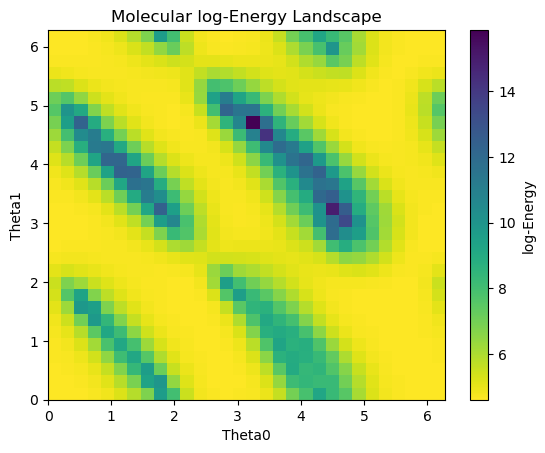

log-energy gt optimized 3.859563441981635


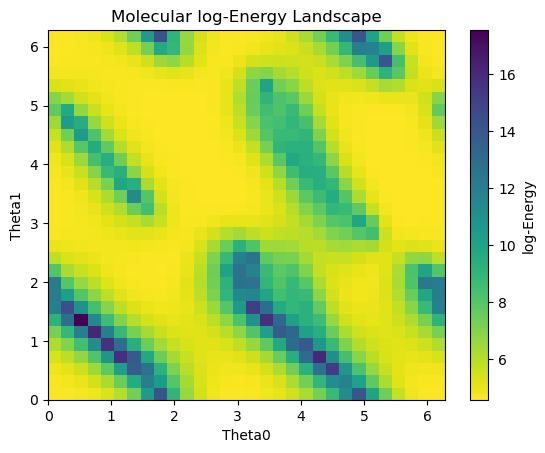

In [15]:
ix_smi = 1
datapoint = dataset.datapoints[ix_smi]
print(f'smi: {datapoint.canonical_smi}')
data = copy.deepcopy(datapoint)
for ix in range(len(data.pos)): # for each different values of bond lenghts and angles from ground truth data
    data.pos, data.weights = datapoint.pos[ix], datapoint.weights[ix]
    print('log-energy gt optimized', np.log(mmff_energy(pyg_to_mol(data.mol, data, mmff=True, rmsd=True, copy=True))))
    energy_landscape = get_2dheatmap_array(data,ix0=0, ix1=1, num_points = 30)
    #plot heatmap
    plt.figure()
    plt.imshow(np.log(energy_landscape), extent=[0, 2 * np.pi, 0, 2 * np.pi], origin='lower', aspect='auto', cmap='viridis_r')
    plt.colorbar(label='log-Energy')
    plt.xlabel('Theta0')
    plt.ylabel('Theta1')
    plt.title('Molecular log-Energy Landscape')
    plt.show()

## Distributional shift(ground truth vs rdkit-generated data) in bond lengths/bond angles 

In [25]:
ix_smi = 0
datapoint = dataset.datapoints[ix_smi]
data = copy.deepcopy(datapoint)
mols = []
for ix in range(len(data.pos)):
    data.pos, data.weights = datapoint.pos[ix], datapoint.weights[ix]
    mol = pyg_to_mol(data.mol, data, mmff=False, rmsd=True, copy=True)
    mols.append(mol)

get_stds_internal_coords(mols)

(tensor(0.0150), tensor(0.0328), tensor(1.5765))

In [9]:
mols_gen = list(conformers_gen.values())[0]
get_stds_internal_coords(mols_gen)

(tensor(0.0159), tensor(0.0701), tensor(1.5332))

In [10]:
bond_angles = [get_bond_angles(mol) for mol in mols]
bond_angles_gen = [get_bond_angles(mol)[:-1] for mol in mols_gen]
torch.stack(bond_angles + bond_angles_gen).std(dim=0).mean()

tensor(0.1286)

In [11]:
bond_lengths = [get_bond_lengths(mol) for mol in mols]
bond_lengths_gen = [get_bond_lengths(mol) for mol in mols_gen]
torch.stack(bond_lengths + bond_lengths_gen).std(dim=0).mean()

tensor(0.0986)

Hm, the std deviation of bond lengths&bond angles increases when we concatenate [mols_ground truth, mols_gen]. which seems to indicate a distributional shift in the lengths/angles distributions when we are moving from gt to rdkit-generated. Does this explain the energy-shifts?

## Toy task: comparing vargrad vs diffusion loss

In [119]:
def get_likelihood(pkl_file, torsion_updates, sigma = 0.5):
    dummy_data = pickle.load(open(pkl_file, 'rb'))
    num_torsion_angles = len(dummy_data[0].mask_rotate)
    gt_total_perturb = Batch.from_data_list(dummy_data).total_perturb.reshape(-1, num_torsion_angles)
    logprobs = []
    for mode in gt_total_perturb:
        logprob = torch.log(torus.p_differentiable(torsion_updates - mode, sigma) + 1e-15).sum() - 2*np.log(sigma)
        logprobs.append(logprob)
    probs = torch.logsumexp(torch.stack(logprobs), dim=0)
    return probs.item()

In [110]:
def get_likelihood(pkl_file, torsion_updates, sigma = 0.5):
    dummy_data = pickle.load(open(pkl_file, 'rb'))
    num_torsion_angles = len(dummy_data[0].mask_rotate)
    gt_total_perturb = Batch.from_data_list(dummy_data).total_perturb.reshape(-1, num_torsion_angles)
    probs = []
    for mode in gt_total_perturb:
        prob = torus.p_differentiable(torsion_updates - mode, sigma).prod()
        probs.append(prob)
    prob = torch.stack(probs).mean().item()
    return prob ** 10

In [ ]:
from scipy.stats import multivariate_normal

def get_multivariate_gaussian(x, mu, sigma):
    mvn = multivariate_normal(mean = mu, cov = sigma* torch.eye(len(mu)), allow_singular = False, seed = 42)
    return mvn.pdf(x)

def get_likelihood(mean , torsion_updates, sigma ):
    num_torsion_angles = len(dummy_data[0].mask_rotate)
    gt_total_perturb = Batch.from_data_list(dummy_data).total_perturb.reshape(-1, num_torsion_angles)
    gaussians = []
    for mean in gt_total_perturb:
        gaussian = get_multivariate_gaussian(torsion_updates, mean, sigma)
        gaussians.append(gaussian)
    return np.stack(gaussians).mean().item()

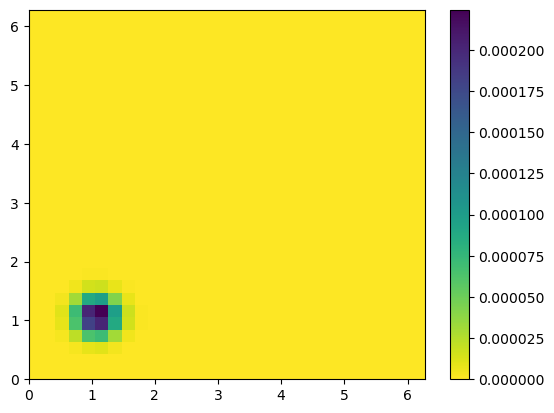

In [186]:
plt.imshow(np.array(probs), extent=[0, 2 * np.pi, 0, 2 * np.pi], origin='lower', aspect='auto', cmap='viridis_r')
plt.colorbar()

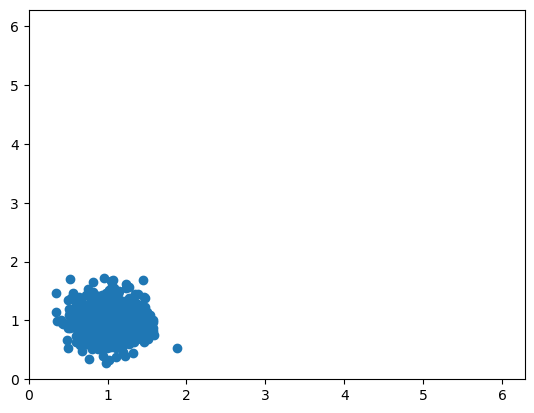

In [ ]:

mean = [1,1,0]
sigma = 0.05 
mvn = multivariate_normal(mean = mean, cov = sigma * torch.eye(len(mean)), allow_singular = False, seed = 42)
# sample from mvn
samples = mvn.rvs(1000)
#samples = np.random.multivariate_normal(mean, cov, 1000)
plt.scatter(samples[:,0], samples[:,1])
plt.xlim(0, 2*np.pi)
plt.ylim(0, 2*np.pi)
plt.show()

In [226]:
mean = [1,1,0]
sigma = 0.05 
mvn = multivariate_normal(mean = mean, cov = sigma * torch.eye(len(mean)), allow_singular = False, seed = 42)


# Visualize the wrapped normal distribution
torsion_angles_linspace = torch.linspace(0, 2*np.pi, 30)
probs = []
for theta0 in torsion_angles_linspace:
    probs.append([])
    for theta1 in torsion_angles_linspace:
        probs[-1].append([])
        for theta2 in torsion_angles_linspace:
            x = torch.Tensor([theta0, theta1, theta2])
            prob = mvn.pdf(x)
            probs[-1][-1].append(prob)
probs = np.array(probs).mean(axis = -1)


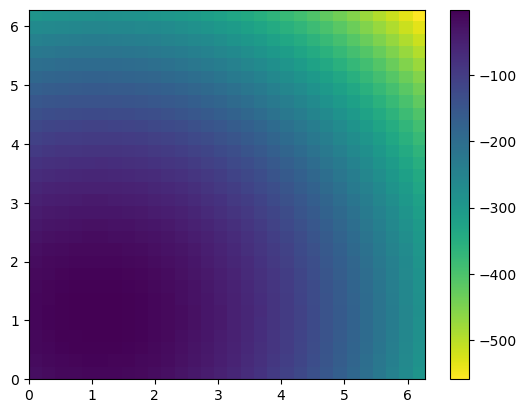

In [228]:
plt.imshow(np.log(probs), extent=[0, 2 * np.pi, 0, 2 * np.pi], origin='lower', aspect='auto', cmap='viridis_r')
plt.colorbar()

In [193]:
def create_dummy_data(smi, dummy_data_pkl, perturbs):
    for batch_idx, batch in enumerate(tqdm.tqdm(loader, total=len(loader))):  # Here, loader is used to go through smiles. But in our case, we are going to focus only on one smiles
        assert len(batch) == 1
        if batch.canonical_smi[0] == smi:
            break 

    data = batch[0]
    assert transform == None
    data.pos = data.pos[0]
    dummy_data = []
    for perturb in perturbs:
        data0 = copy.deepcopy(data)
        new_pos = modify_conformer(data0.pos, data0.edge_index.T[data0.edge_mask], data0.mask_rotate, perturb, as_numpy=False) 
        data0.pos = new_pos
        data0.total_perturb = torch.Tensor(perturb)
        #data0.mask_rotate = torch.tensor(data0.mask_rotate)
        dummy_data.append(copy.deepcopy(data0))
    # Save the dummy data
    pickle.dump(dummy_data, open(dummy_data_pkl, 'wb'))
    return dummy_data

In [194]:
dummy_data = create_dummy_data(smi = 'Brc1cc2c(cc1Cn1c(-c3cncs3)nc3ccccc31)OCO2', dummy_data_pkl = 'dummy_data_gaussian.pkl', perturbs = samples)

  0%|          | 1/9295 [00:00<02:06, 73.43it/s]


In [199]:
plot_aligned_confs(dummy_data)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

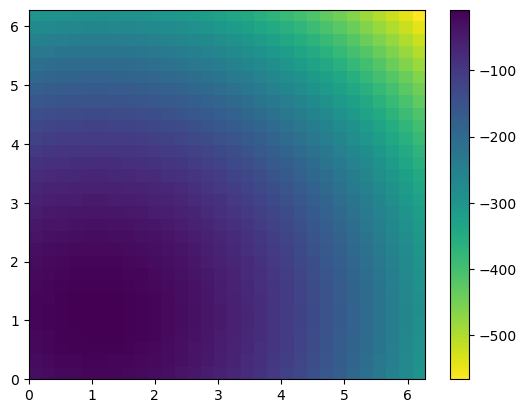

In [188]:
# Sample points with get_likelihood function 
plt.imshow(np.log(np.array(probs)), extent=[0, 2 * np.pi, 0, 2 * np.pi], origin='lower', aspect='auto', cmap='viridis_r')
plt.colorbar()

## Function that needs to be parallelized 

In [8]:
import torch 
import numpy as np
import copy
from scipy.spatial.transform import Rotation as R

In [9]:
def modify_conformer(pos_input, edge_index, mask_rotate, torsion_updates_input, as_numpy=False):
    '''
    Modifies the conformer's 3D coordinates based on the torsion updates.
    Args:
        pos_input: (N, 3) tensor of 3D coordinates
        edge_index: (E, 2) tensor of edge indices
        mask_rotate: (E, N) tensor of boolean masks indicating which atoms are rotated by each edge
        torsion_updates_input: (K,) tensor of torsion updates
        as_numpy: whether to return the output as a numpy array
    Returns:
        pos: (N, 3) tensor of modified 3D coordinates
    '''
    pos = copy.deepcopy(pos_input)
    if type(pos) != np.ndarray: pos = pos.cpu().numpy()
    if type(torsion_updates_input) != np.ndarray: 
        torsion_updates = copy.deepcopy(torsion_updates_input.detach()).cpu().numpy()
    else:
        torsion_updates = torsion_updates_input
    for idx_edge, e in enumerate(edge_index.cpu().numpy()):
        if torsion_updates[idx_edge] == 0:
            continue
        u, v = int(e[0]), int(e[1])

        # check if need to reverse the edge, v should be connected to the part that gets rotated
        assert not mask_rotate[idx_edge, u] or not mask_rotate[idx_edge, u.item()]
        assert mask_rotate[idx_edge, v]

        rot_vec = pos[u] - pos[v] # convention: positive rotation if pointing inwards. NOTE: DIFFERENT FROM THE PAPER!
        rot_vec = rot_vec * torsion_updates[idx_edge] / np.linalg.norm(rot_vec) # idx_edge!
        rot_mat = R.from_rotvec(rot_vec).as_matrix()

        pos[mask_rotate[idx_edge]] = (pos[mask_rotate[idx_edge]] - pos[v]) @ rot_mat.T + pos[v]

    if not as_numpy: pos = torch.from_numpy(pos.astype(np.float32))
    return pos

In [16]:
pos_input = torch.Tensor([[-2.4816,  0.4621, -0.0431],
        [-1.6341, -1.2250, -0.0677],
        [-0.4341, -1.3996, -0.6324],
        [ 0.0653, -2.7274, -0.6143],
        [-0.5959, -3.7824, -0.0696],
        [-1.8320, -3.5810,  0.5093],
        [-2.3478, -2.3003,  0.5082],
        [-3.3011, -2.1072,  0.9473],
        [-2.3012, -4.8075,  0.9934],
        [-1.5430, -5.8271,  0.3678],
        [-0.3348, -5.1506,  0.0761],
        [-2.0349, -6.0840, -0.5935],
        [-1.3852, -6.7025,  1.0297],
        [ 1.0249, -2.9138, -1.0583],
        [ 0.4228, -0.3848, -1.2090],
        [ 1.6921, -0.1238, -0.6248],
        [ 2.7165, -1.0341, -0.5894],
        [ 2.9031, -2.3065, -1.0737],
        [ 4.0671, -3.0228, -0.8909],
        [ 5.1118, -2.4565, -0.1899],
        [ 4.9508, -1.1830,  0.3064],
        [ 3.7548, -0.4785,  0.1045],
        [ 3.3412,  0.7348,  0.4714],
        [ 2.0752,  0.9637,  0.0330],
        [ 1.3364,  2.2032,  0.3775],
        [ 1.8716,  3.4326,  0.6637],
        [ 1.0607,  4.3791,  1.0006],
        [-0.2420,  4.1424,  1.0598],
        [-0.3250,  2.4963,  0.6162],
        [-1.0430,  4.8552,  1.3315],
        [ 2.9710,  3.5967,  0.6027],
        [ 5.7457, -0.7001,  0.8632],
        [ 6.0342, -3.0124, -0.0396],
        [ 4.2095, -4.0232, -1.2741],
        [ 2.1060, -2.7773, -1.6202],
        [ 0.5136, -0.5947, -2.3265],
        [-0.1138,  0.6163, -1.2253]])


edge_index = torch.Tensor([[14,  2],
        [15, 14],
        [23, 24]])

mask_rotate = np.array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True,
         True],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True,  True,  True,
         True,  True,  True,  True, False, False, False, False, False,
        False]])

torsion_updates_input = np.array([ 0.77378716, -0.15896694,  1.56961906])

modify_conformer(pos_input, edge_index, mask_rotate, torsion_updates_input, as_numpy=False)

tensor([[-1.1387,  0.7159,  1.4106],
        [-1.2065, -0.9821,  0.5876],
        [-0.5141, -1.2512, -0.5248],
        [-0.6904, -2.5544, -1.0573],
        [-1.4973, -3.4992, -0.5068],
        [-2.2020, -3.2023,  0.6416],
        [-2.0538, -1.9421,  1.1859],
        [-2.5831, -1.6773,  2.0739],
        [-2.9510, -4.3267,  1.0068],
        [-3.0172, -5.1764, -0.1244],
        [-1.8388, -4.8203, -0.8222],
        [-3.8884, -4.8673, -0.7390],
        [-3.0329, -6.2495,  0.1538],
        [-0.1547, -2.8132, -1.9510],
        [ 0.4228, -0.3848, -1.2090],
        [ 1.6921, -0.1238, -0.6248],
        [ 2.7165, -1.0341, -0.5894],
        [ 2.9031, -2.3065, -1.0737],
        [ 4.0671, -3.0228, -0.8909],
        [ 5.1118, -2.4565, -0.1899],
        [ 4.9508, -1.1830,  0.3064],
        [ 3.7548, -0.4785,  0.1045],
        [ 3.3412,  0.7348,  0.4714],
        [ 2.0752,  0.9637,  0.0330],
        [ 1.3364,  2.2032,  0.3775],
        [ 0.9720,  2.6281,  1.6291],
        [ 0.2762,  3.7120,  1.7186],
 